# Classification using Decision Tree & Random Forest
### Breast Cancer Wisconsin (Diagnostic) Data Set
---------------------

We will be working on a classification problem using decision trees & random forest algorithms on the data set Breast Cancer data set. We will load the data from sklearn but the original data and information can be found on UCI machine learning repository [(link)](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)).

This dataset consists of 569 observations and 30 features. Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

The goal is to train a model that learns the features to diagnose (predict) if the cancer cells are malignant or benign (target).

Note: Data has no missing values.

In [140]:
#imports
from sklearn.datasets import load_breast_cancer  #dataset

from sklearn.tree import DecisionTreeClassifier   #algorithm
from sklearn.ensemble import RandomForestClassifier   #algorithm
from sklearn.ensemble import GradientBoostingClassifier   #algorithm

from sklearn.model_selection import train_test_split   #split dataset to train and test
from sklearn.tree import export_graphviz    #visualize decison tree
import graphviz   #read plot files for decision trees

import matplotlib.pyplot as plt   #for regurlar plots
import pandas as pd
import numpy as np

#settings
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

We shall the load the data, split it into train and test and build a decision tree model using the default settings.

In [141]:
#Load data
cancer = load_breast_cancer()

#split data
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify=cancer.target, random_state=42)

#build model
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

Accuracy on training set: 1.000
Accuracy on test set: 0.937


We received an accuracy of 1 on training set while the model did not generalize well on test. The reason for this is over fitting. We over trained the model with every feature to perfectly fit and made it a complex model.

To overcome this, we need to control the complexity of the tree. Let's do a pre-prunning to restrict the depth of the tree. Let's set the max depth to 4 and train again.

In [142]:
#build model with pre-prunning
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

Accuracy on training set: 0.988
Accuracy on test set: 0.951


Accuracy is improved this time on the test data while the complexity of the model is reduced.

Lets visualize the decision tree we have built.

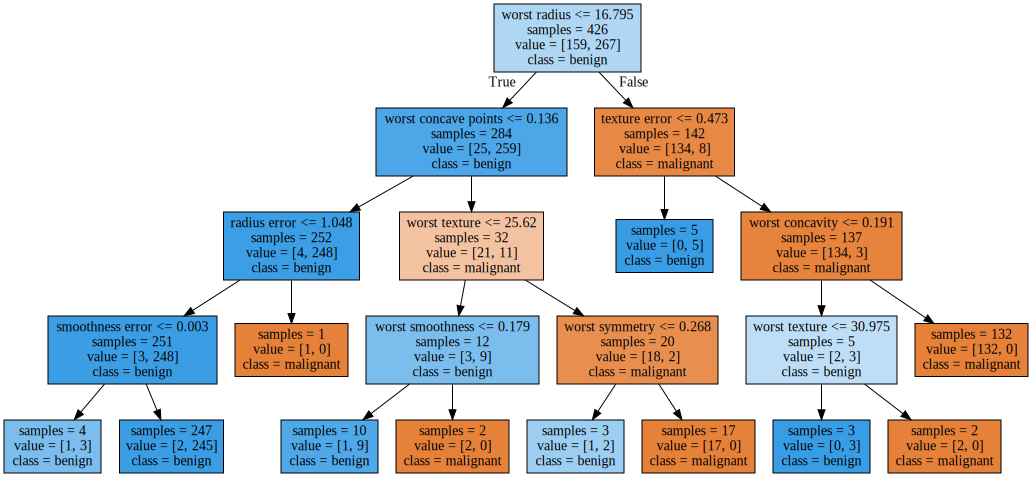

In [143]:
#create plot file
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"], 
                feature_names=cancer.feature_names, impurity=False, filled=True)

#open plot file and display
with open("tree.dot") as f:
    dot_graph = f.read()
    
display(graphviz.Source(dot_graph))

Tree for our model with depth 4. In this model we have "worst radius" feature as root.

Lets look at the summary of feature importance visually instead of looking at the entire tree.

<Figure size 720x720 with 0 Axes>

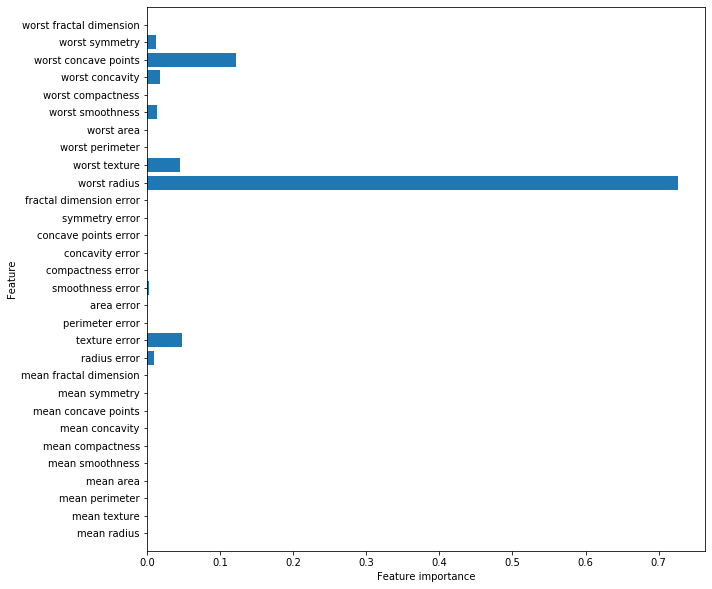

In [144]:
#function to plot feature importance
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plt.figure(figsize=(10,10))
plot_feature_importances_cancer(tree)

The most important feature in the dataset is "worst radius" and hence it is selected as the root node. Then we have "worst concave points" and the rest.

________________________
Getting back to model evaluation, we have looked into just accuracy. Lets look into more precise performance metric for our situation to evaluate the model.

In [145]:
#func for confusion matrix
def conf_matrix(model, xtest, ytest):
    pred = model.predict(xtest)
    cf = pd.crosstab(ytest, pred,rownames=['True'], colnames=['Predicted'], margins=True)
    return cf

cf_tree = conf_matrix(tree, X_test, y_test)
cf_tree

Predicted,0,1,All
True,,,
0,49,4,53
1,3,87,90
All,52,91,143


Here is the confusion matrix. We have 136 correct predictions and 7 incorrect. We have to focus on the incorrect here. Specially where the actual value is "Malignant or 0" and the predicted value is "Benign or 1". This is **False Negative**. 

Since our goal is to predict cancer cells correctly and predicting True case as False will have extreme consequences. So we have to choose **TPR-True Positive Rate (recall)** as our measure to avoid false negatives.

Let's calculate Recall.

In [146]:
#func for calc recall
def recall(cf):
    recall = cf.iloc[0,0]/(cf.iloc[0,0]+cf.iloc[1,0])
    return recall

print("Recall (TPR):", recall(cf_tree))

Recall (TPR): 0.9423076923076923


0.94 is not a great recall rate in our case. We need to improve this metric to as close as to 1.

------------------------
### Random Forest
Let's build a model using Random forest which is a better version of decision trees. Random forests tend to correct the overfit problem in decision trees by randomly building collection of decision trees which are different from each other.

Check for accuracy, confusion matrix and recall

In [147]:
#build forest
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

#print trian, test accuracy
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Accuracy on training set: 1.000
Accuracy on test set: 0.958


In [148]:
#confusion matrix for forest
cf_forest = conf_matrix(forest, X_test, y_test)
cf_forest

Predicted,0,1,All
True,,,
0,49,4,53
1,2,88,90
All,51,92,143


In [149]:
#calc recall
print("Recall (TPR):", recall(cf_forest))

Recall (TPR): 0.9607843137254902


This model does better in improving the recall score.

Let's visualize the important features for this model.

<Figure size 720x720 with 0 Axes>

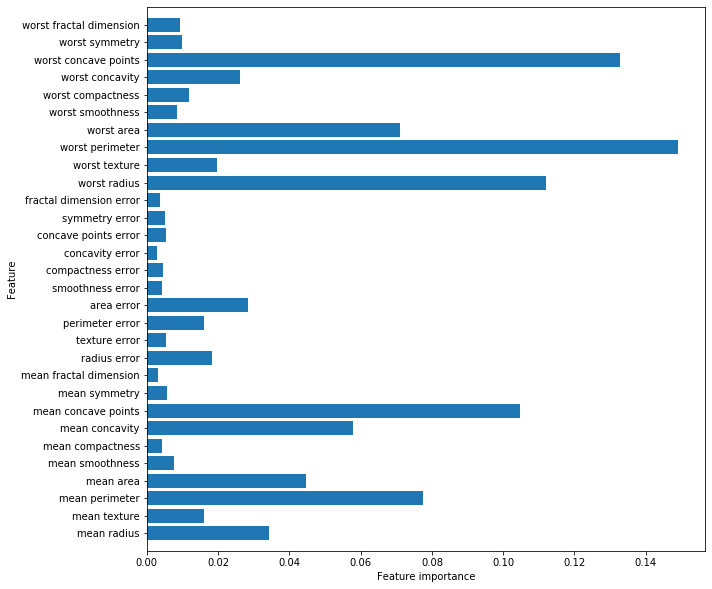

In [150]:
plt.figure(figsize=(10,10))
plot_feature_importances_cancer(forest)

In contrast to Decision tree, the random forest gives importance to many features. Though it gives a high importance to "worst concave points" as in DT, the highest is given to "worst perimeter". Thus randomness in forests try to capture a broader picture.



---------------------
### Gradient boosted regression trees
Finally lets use one more algorithm to improve our model which is Gradient boosted regression trees (or simply gradient boosting machines). Like random forests, this model builds multiple trees but simpler and shallow (small depth) for each tree. And unlike random forests, this model builds trees in serial manner where each succeeding tree correct the mistakes of previoius one.

Let's build a model, calculate scores and visualize important features.

In [151]:
#build gradient boost
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

#calc accuracy
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Accuracy on training set: 1.000
Accuracy on test set: 0.958


In [152]:
#confusion matirx for gbrt
cf_gbrt = conf_matrix(gbrt, X_test, y_test)
cf_gbrt

Predicted,0,1,All
True,,,
0,48,5,53
1,1,89,90
All,49,94,143


In [153]:
#calc recall
print("Recall (TPR):", recall(cf_gbrt))

Recall (TPR): 0.9795918367346939


This model is by far the best is for our case in minimizing the "False negatives" giving a high recall rate of approx. **98%**.

<Figure size 720x720 with 0 Axes>

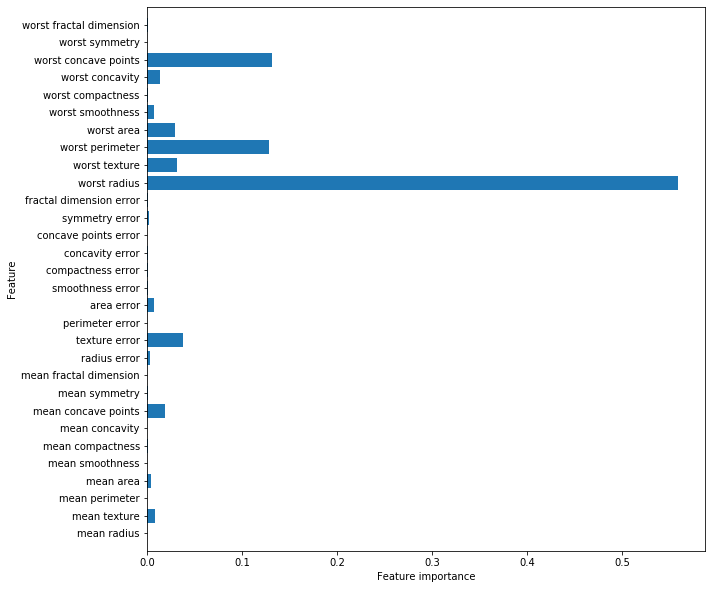

In [154]:
plt.figure(figsize=(10,10))
plot_feature_importances_cancer(gbrt)

This plot is simillar to decision trees. Best feature is being "worst radius" with high value while the rest are either low or zeros.

-------------------------

### Hyperparameter optimization
Since this model worked the best, lets tweak few important paramaters in this model to see if we can still improve the model.

- max_depth: 3 by default. More depth means more complex
- learning_rate: 0.1 by default. High rate means stronger corrections and complex model

In [155]:
#hyper parameter optimization

def gbrt_opt(tree_depth, learn_rate):
    gbrt = GradientBoostingClassifier(random_state=0, max_depth=tree_depth, learning_rate= learn_rate)
    gbrt.fit(X_train, y_train)

    #confusion matirx for gbrt
    cf_gbrt = conf_matrix(gbrt, X_test, y_test)
    
    #calc recall
    return recall(cf_gbrt)

recall_dict = {}
for depth in range(1,6):
    rate_dict = {}
    for rate in np.linspace(0.02, 0.2, 10):
        rate_fix = round(rate, 2)
        rate_dict[rate_fix] = gbrt_opt(depth, rate_fix)
    recall_dict[depth] = rate_dict


In [156]:
#find best performing k-fold and k-NN
max_list = {}
for k,v in recall_dict.items():
    each_rate_max_dict = {}
    rate_dict = max(v, key=v.get)
    each_rate_max_dict[rate_dict] = v[rate_dict]
    max_list[k] = each_rate_max_dict

max_list

{1: {0.12: 0.98},
 2: {0.2: 0.98},
 3: {0.08: 0.9795918367346939},
 4: {0.1: 0.96},
 5: {0.1: 0.9423076923076923}}

For each iteration of depth from 1 to 5 and each iteration of learning rate 0.02 to 0.2 (intervals of 0.02) we captured the recall (TPR) and displayed the max recall recorded in each combination.

We observed as the depth increased the recall is decreasing as the learning rate increased the recall rate is increasing.

The max we could achieve is **98%** which is very close to earlier model without optimization. Though we could not improve the model this is worth giving a try.

### Conclusion
Trying with different models we could achieve a high recall rate of **98%** which is good.
The best performing model in achieving this goal is Gradient Boost Regression Trees.

-----------------------

# Comparing k-NN and Decision trees and Forests

- While k-NN is instance-based learning algorithm, DT/RF/GBRT are parameter-bases learning algorithms
- k-NN uses Euclidean distance to find best match and does not learn anything about the feature, while the other algoritms try to learn the features and measure their importance.
- k-NN's are computationally expensive, DT is also computationally expensive. While RF/GBRT are relatively faster due to smaller and less complex trees due to controlled parameters.
- k-NN's just gives the output prediction while the trees also gives the process of making the decision which is highly useful in few scenarios where we need to explain why a decision is made.
------------------------
